# read grace files

In [10]:
from grace.base import GraphAttrs
from grace.io import read_graph
from grace.napari.utils import EdgeColor
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [43]:
path = "/Users/kulicna/Desktop/dataset/shape_stars/infer/MRC_Synthetic_File_006.grace"
# path = "/Users/kulicna/Desktop/dataset/shape_stars/train/MRC_Synthetic_File_000.grace"

dataset = read_graph(Path(path))

In [44]:
dataset.metadata

{'image_filename': 'MRC_Synthetic_File_006'}

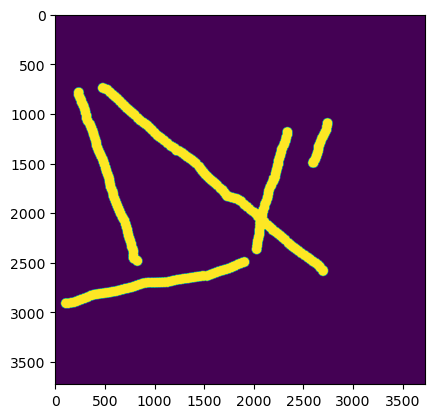

In [45]:
plt.imshow(dataset.annotation)

In [46]:
graph = dataset.graph

In [47]:
graph

In [48]:
graph.nodes(data=True)[0]

{<GraphAttrs.NODE_X: 'x'>: 1062.1717529296875,
 <GraphAttrs.NODE_Y: 'y'>: 3594.8076171875,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

Text(0.5, 1.0, 'MRC_Synthetic_File_006')

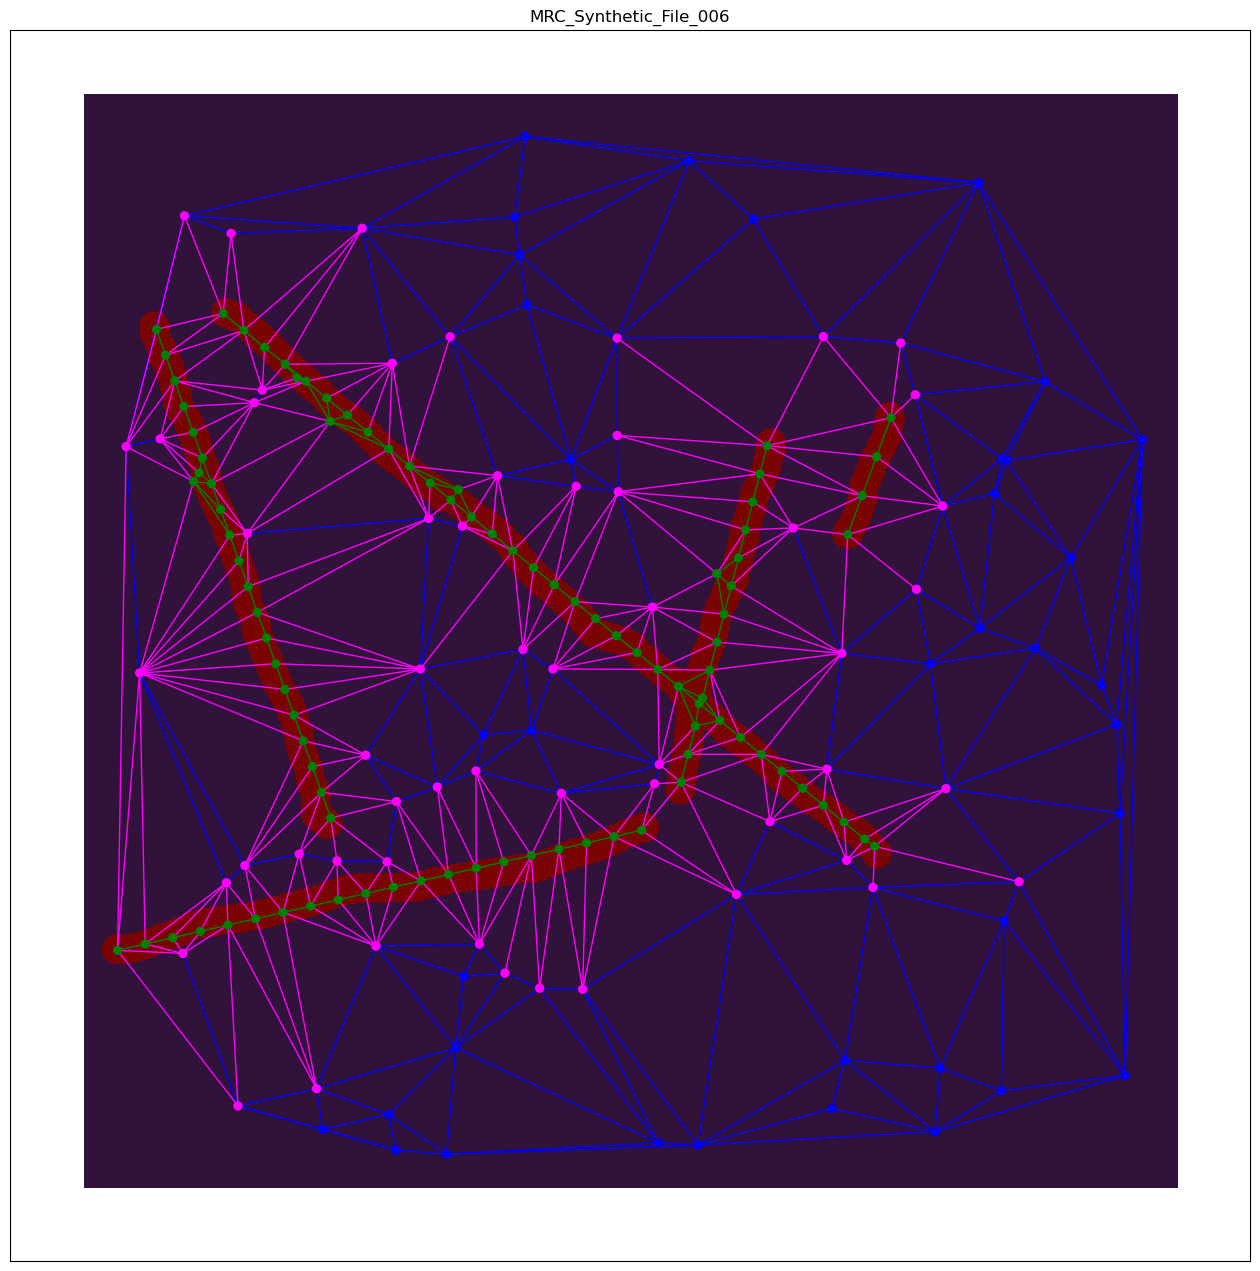

In [49]:

fig, ax = plt.subplots(figsize=(16, 16))

# node positions
pos = {
    idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) 
    for idx, node in graph.nodes(data=True)
}
# edge annotations
edge_gt = [graph[u][v][GraphAttrs.EDGE_GROUND_TRUTH] for u, v in graph.edges]
edge_colors = [EdgeColor[gt.name].value for gt in edge_gt]

node_colors = [
    EdgeColor[node_attrs[GraphAttrs.NODE_GROUND_TRUTH].name].value 
    for _, node_attrs in graph.nodes(data=True)
]

ax.imshow(dataset.annotation, cmap=plt.cm.turbo, interpolation="none")

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(
    dataset.graph, 
    ax=ax, 
    pos=pos, 
    with_labels=False, 
    # node_color="w", 
    node_size=32,
    edge_color=edge_colors,
    node_color=node_colors,
)

ax.set_title(dataset.metadata["image_filename"])

In [42]:
np.unique(dataset.annotation)

array([0, 1])

In [34]:
dataset

GraceFileDataset(metadata={'image_filename': 'MRC_Synthetic_File_008'}, graph=<networkx.classes.graph.Graph object at 0x7ff774100820>, annotation=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]))

In [15]:
img = "/Users/kulicna/Desktop/dataset/data_squares_simple/MRC_Synthetic_File_000.mrc"
import mrcfile

with mrcfile.open(img, "r") as mrc:
    # image_data = mrc.data.astype(int)
    image_data = mrc.data

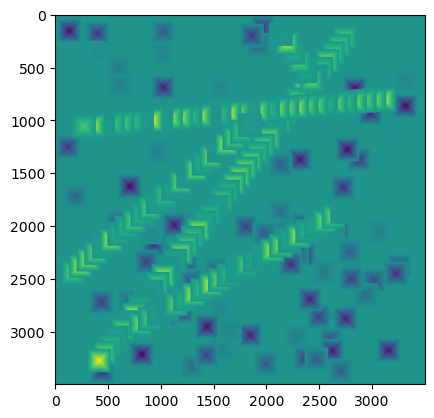

In [16]:
plt.imshow(image_data)